In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from numpy import random
from sklearn.model_selection import train_test_split
import os
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import r2_score
from random import seed
from random import randrange
import timeit
import tensorflow as tf
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [2]:
%load_ext autoreload
%autoreload 
%reload_ext autoreload
import utility_script_multi_sklearn as us

In [3]:
SNOMED_scored=pd.read_csv("../input/featurized-physionet-challenge-2020-data/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv("../input/featurized-physionet-challenge-2020-data/SNOMED_mappings_unscored.csv", sep=";")

In [4]:
data = pd.read_csv('../input/featurized-physionet-challenge-2020-data/ecg_data_with_labels.csv')

In [5]:
conf_weights = pd.read_csv("../input/featurized-physionet-challenge-2020-data/weights.csv", sep=",", header= 0, index_col=0 )

In [6]:
data.head()

Unnamed: 0    0     1          2           3           4           5  \
0           0  0.0  74.0   0.818758  100.334448   99.009901  102.040816   
1           1  0.0  49.0   1.760567   76.923583   76.142132   81.300813   
2           2  0.0  81.0  37.708984  141.308685   31.120332  185.185185   
3           3  0.0  45.0  25.252184  109.090909   70.754717  153.846154   
4           4  0.0  53.0   6.227148  119.521912  101.694915  144.230769   

            6             7         8  ...         103        104         105  \
0  100.537248  10108.408537  0.017732  ...  100.334448  97.087379  105.263158   
1   77.742365   6046.974958  0.010598  ...   77.519380  75.376884   81.081081   
2  131.051603  18596.490035  0.083807  ...  144.927536  30.895984  227.272727   
3  110.019668  12742.000091  0.182643  ...   91.743119  72.639225  285.714286   
4  120.016109  14442.643773  0.182657  ...  118.812347  84.745763  267.857143   

          106        107         108        109         110         111  \
0  100.470283  14.954241  100.334448  83.102493  128.205128  102.729465   
1   77.848763   2.431188   77.720207  74.812968   82.872928   77.885993   
2  137.312455  58.608281  136.986301  31.023785  272.727273  139.162091   
3  120.996071  61.174821   93.167702  68.181818  285.714286  123.129987   
4  128.928710  47.516386  120.000000  80.862534  256.410256  133.257833   

      labels  
0   59118001  
1  426783006  
2  164889003  
3  164889003  
4  164884008  

[5 rows x 114 columns]

In [7]:
print(np.where(data.iloc[:,:-1].isna()))
print(data.index[np.isinf(data.iloc[:,:-1]).any(1)])
#print(data.columns.to_series()[np.isinf(data.iloc[:,:-1]).any()])

(array([   10,    10,    10, ..., 42715, 42715, 42715]), array([ 86,  87,  90, ...,  86, 103, 108]))
Int64Index([  632,  3697,  3939,  4014,  4518,  5058,  5679,  5891,  6062,
             8216, 13699, 13724, 19728, 20086, 23641, 23989, 24402, 26278,
            27813, 28736, 29211, 29417, 29893, 32200, 34761, 36265, 37771,
            38037, 38738, 38760, 38789, 38790, 38793, 40416, 42518, 42715],
           dtype='int64')


In [8]:
data.shape

(42720, 114)

In [9]:
data = data.dropna()

In [10]:
#data = data.replace([np.inf, -np.inf], 0)

In [11]:
data.shape

(42574, 114)

About 150 ECG-recordings removed

In [12]:
print(np.where(data.iloc[:,1:-1].isna()))
print(data.index[np.isinf(data.iloc[:,1:-1]).any(1)])
#print(data.columns.to_series()[np.isinf(data.iloc[:,1:-1]).any()])

(array([], dtype=int64), array([], dtype=int64))
Int64Index([], dtype='int64')


In [13]:
y_data = data['labels']

In [14]:
X_data = data.iloc[:,1:-1]

In [15]:
data.iloc[:,1:]

0     1          2           3           4           5           6  \
0      0.0  74.0   0.818758  100.334448   99.009901  102.040816  100.537248   
1      0.0  49.0   1.760567   76.923583   76.142132   81.300813   77.742365   
2      0.0  81.0  37.708984  141.308685   31.120332  185.185185  131.051603   
3      0.0  45.0  25.252184  109.090909   70.754717  153.846154  110.019668   
4      0.0  53.0   6.227148  119.521912  101.694915  144.230769  120.016109   
...    ...   ...        ...         ...         ...         ...         ...   
42714  0.0  69.0   7.297528   83.857483   43.165468  100.000000   84.698054   
42716  0.0  66.0  15.661281  106.951872   77.821012  162.162162  111.835712   
42717  0.0  75.0  24.199197   74.074074   54.005401  172.910663   82.825268   
42718  0.0  75.0   5.567916   71.770335   60.544904  117.878193   72.181759   
42719  0.0  61.0   8.415853   74.626866   58.939096  132.743363   75.134926   

                  7         8         9  ...         103        104  \
0      10108.408537  0.017732  0.005000  ...  100.334448  97.087379   
1       6046.974958  0.010598  0.509000  ...   77.519380  75.376884   
2      18596.490035  0.083807  0.727000  ...  144.927536  30.895984   
3      12742.000091  0.182643  0.757000  ...   91.743119  72.639225   
4      14442.643773  0.182657  1.633000  ...  118.812347  84.745763   
...             ...       ...       ...  ...         ...        ...   
42714   7227.014241  0.000296  0.001149  ...   84.151473  39.447732   
42716  12752.502188  0.000609  0.001320  ...  106.951872  52.310375   
42717   7445.626183  0.000183  0.000668  ...   74.028406  43.699927   
42718   5241.208078  0.000082  0.000505  ...   71.856287  59.113300   
42719   5716.083762  0.001200  0.002346  ...   72.727380  29.600395   

              105         106         107         108        109         110  \
0      105.263158  100.470283   14.954241  100.334448  83.102493  128.205128   
1       81.081081   77.848763    2.431188   77.720207  74.812968   82.872928   
2      227.272727  137.312455   58.608281  136.986301  31.023785  272.727273   
3      285.714286  120.996071   61.174821   93.167702  68.181818  285.714286   
4      267.857143  128.928710   47.516386  120.000000  80.862534  256.410256   
...           ...         ...         ...         ...        ...         ...   
42714  115.384615   83.865065   11.183673   84.388186  38.961039  118.110236   
42716  674.157303  124.437248  109.953989  106.761566  55.147059  952.380952   
42717  402.684564   87.165430   54.370778   74.580514  42.765502  431.654676   
42718  129.310345   72.224439    8.011272   71.770335  61.855670  144.578313   
42719  223.048327   76.852039   30.662184   73.619632  29.140359  232.558140   

              111     labels  
0      102.729465   59118001  
1       77.885993  426783006  
2      139.162091  164889003  
3      123.129987  164889003  
4      133.257833  164884008  
...           ...        ...  
42714   83.813103  164865005  
42716  131.061693  164865005  
42717   87.921362  164865005  
42718   72.411308  164865005  
42719   78.216127  164865005  

[42574 rows x 113 columns]

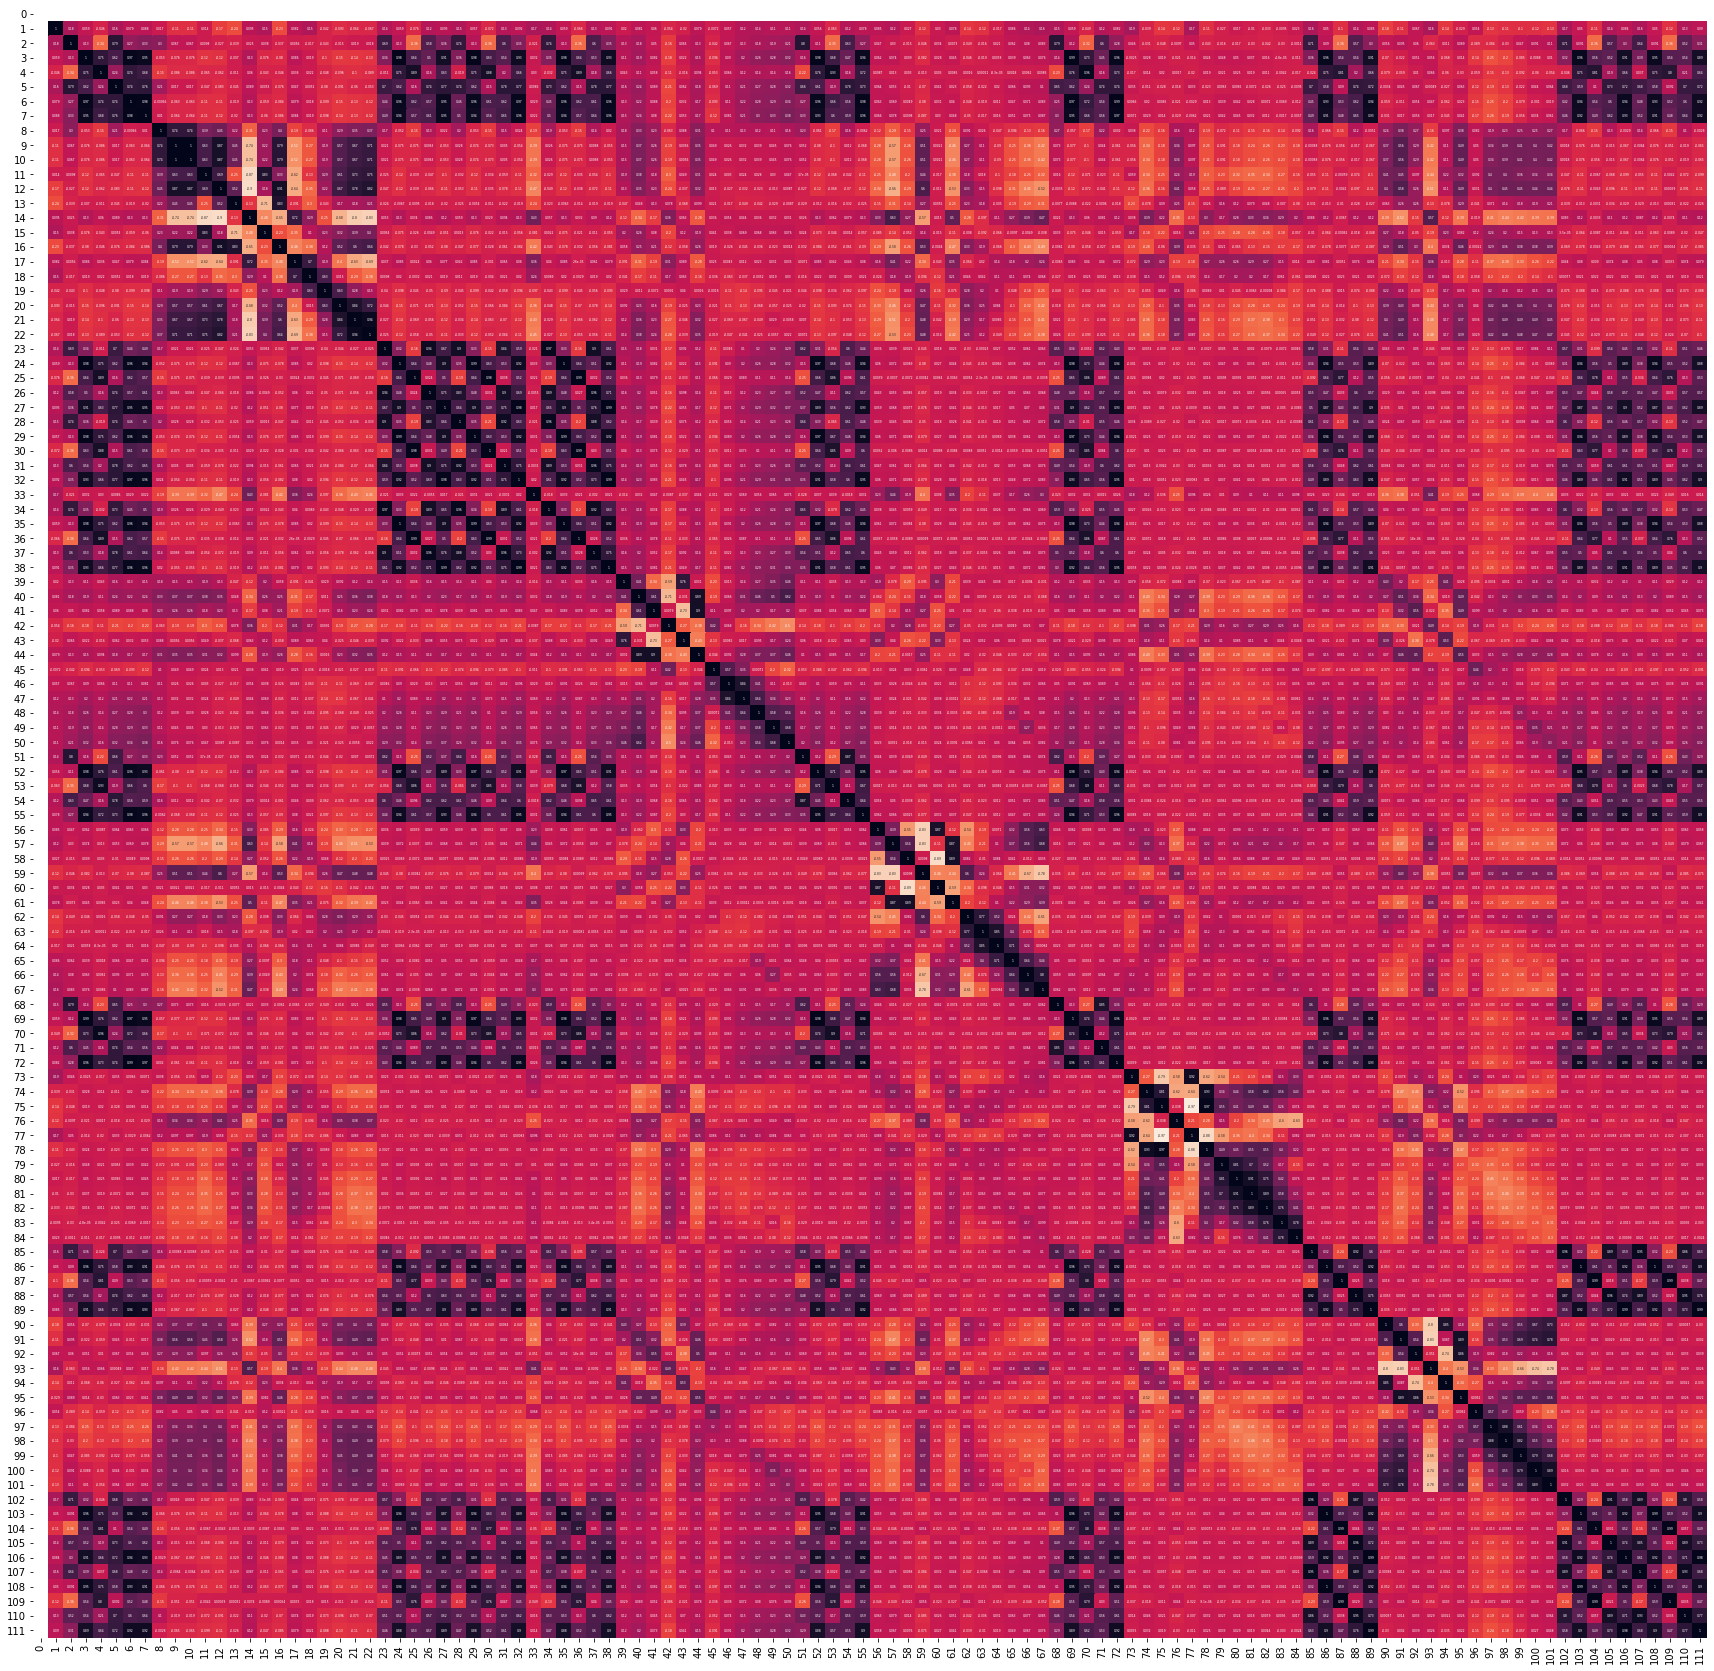

In [16]:
import seaborn as sns
plt.figure(figsize=(30,30))
cor = data.iloc[:,1:].corr()
sns.heatmap(cor, cmap="rocket_r", annot=True,cbar=False, annot_kws={"size": 3})
plt.show()

In [17]:
def making_undef_class(labels):
    df_labels = pd.DataFrame(labels)
    for i in range(len(SNOMED_unscored.iloc[0:,1])):
        df_labels.replace(to_replace=str(SNOMED_unscored.iloc[i,1]), inplace=True ,value="undefined class", regex=True)
    return df_labels

  
df_y = making_undef_class(y_data)

In [18]:
y_data.unique()

array(['59118001', '426783006', '164889003', ..., '368009,427084000',
       '698247007,74390002', '164895002,164896001,164865005,164889003'],
      dtype=object)

In [19]:
from sklearn.preprocessing import MultiLabelBinarizer
one_hot = MultiLabelBinarizer()
y=one_hot.fit_transform(df_y['labels'].str.split(pat=','))
print(one_hot.classes_)
print("classes: {}".format(y.shape[1]))

['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '17338001' '251146004' '270492004' '284470004'
 '39732003' '426177001' '426627000' '426783006' '427084000' '427172004'
 '427393009' '445118002' '47665007' '59118001' '59931005' '63593006'
 '698252002' '713426002' '713427006' 'undefined class']
classes: 28


In [20]:
y = np.delete(y, -1, axis=1)

In [21]:
norsk_liste = ['pacing-rytme', 'forlenget qt-intervall', 'atrieflimmer','atrieflutter','venstre grenblokk','unormal Q-bølge','unormal T-bølge','forlenget PR-intervall', 'ventrikulære premature slag','lav QRS-spenning','1.grads AV-blokk','prematur atriell kontraksjon',
               'venstre akse avvik','sinusbradykardi','bradykardi','sinus rytme', 'sinus takykardi', 'prematur ventrikulær kontraksjon','sinusarytmi','venstre fremre fascikulærblokk','høyre akse avvik','høyre grenblokk','invertert T-bølge','supraventrikulære premature slag',
               'uspesifikk intraventrikulær ledningsforstyrrelse','ufullstendig høyre grenblokk','komplett høyre grenblokk']

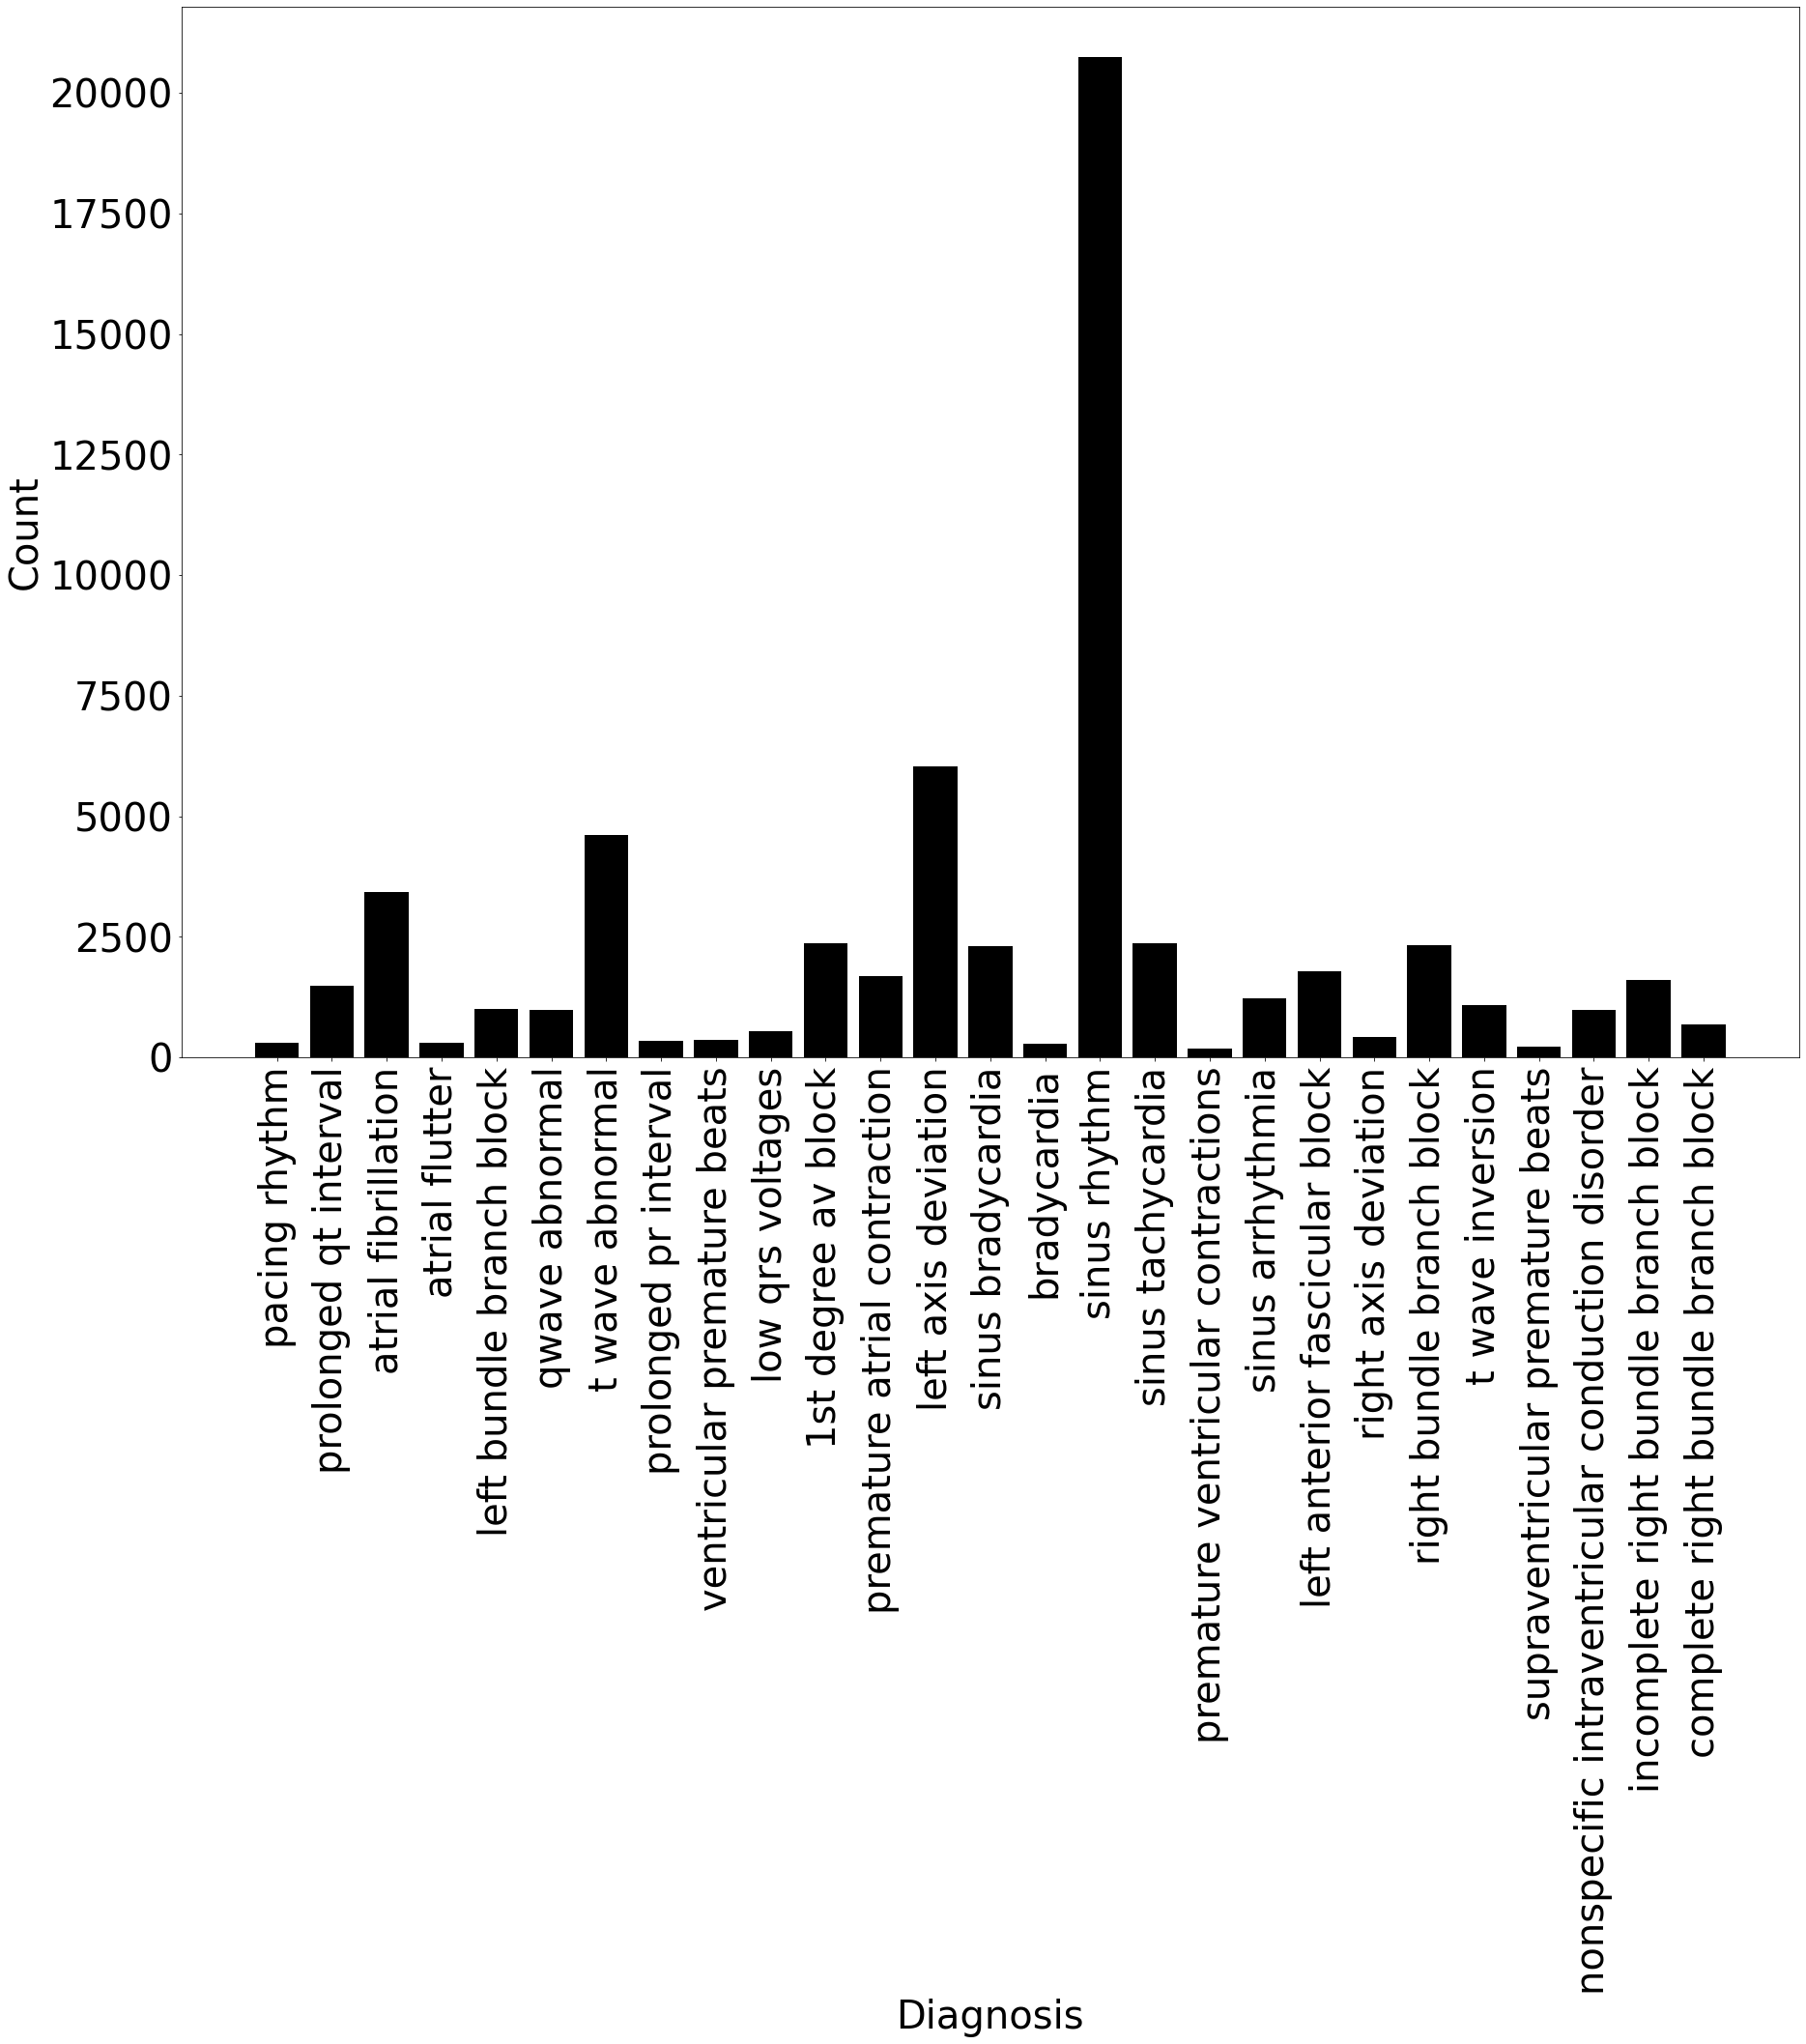

In [22]:
us.plot_classes(one_hot.classes_[0:-1],SNOMED_scored, y)

In [23]:
#@title Transform our One Hot encoded multilabel output to a new type of label where all can be represented by a number:
from sklearn.preprocessing import LabelEncoder

def get_new_labels(y):
    y_new = LabelEncoder().fit_transform([''.join(str(l)) for l in y])
    return y_new

y_temp_new = get_new_labels(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_temp_new))))

Total number of unique combinations of diagnosis: 1396


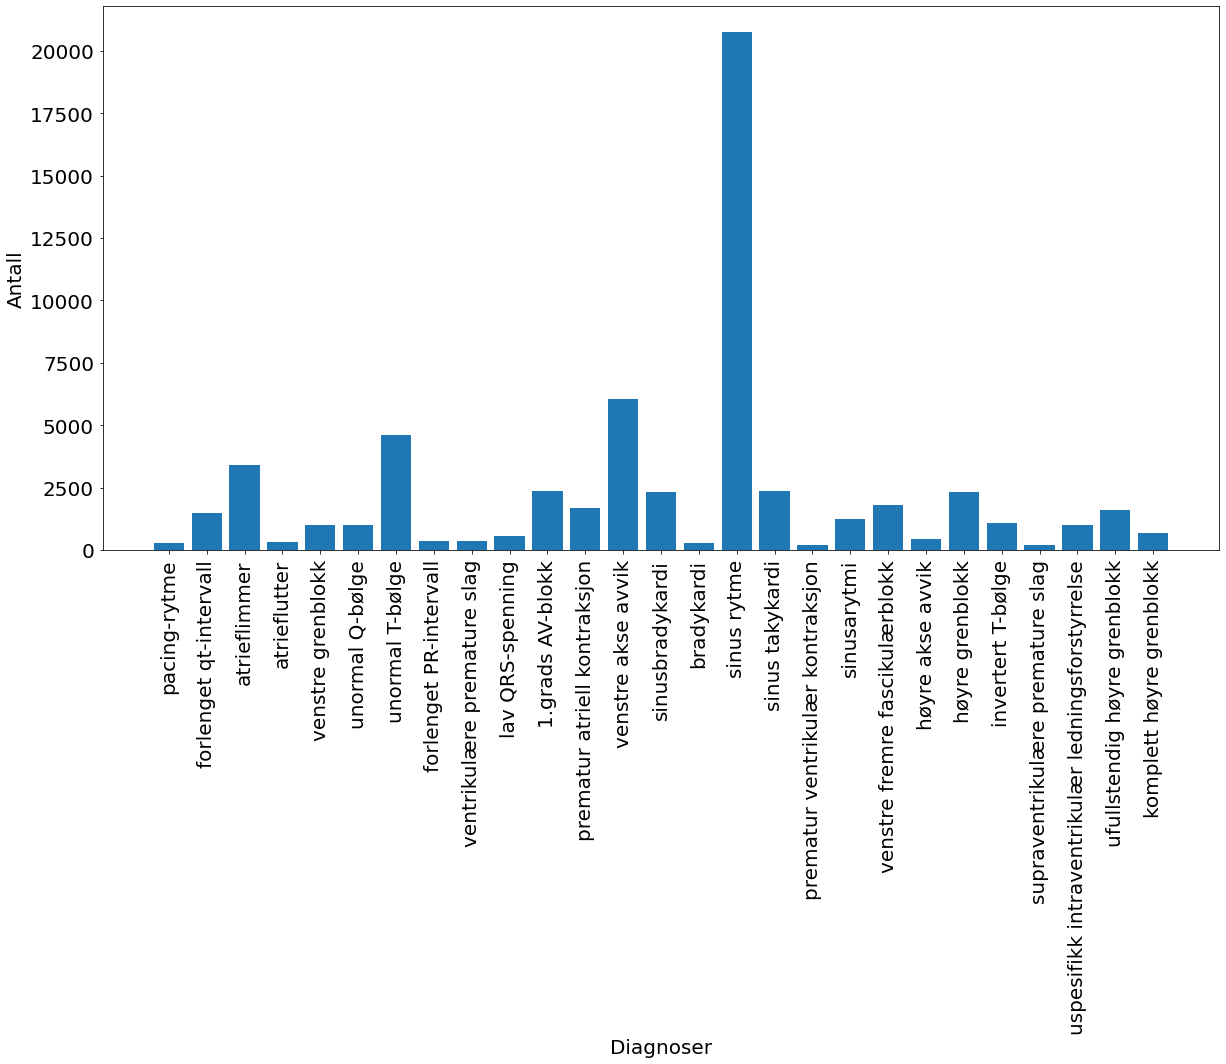

In [24]:
us.plot_classes_2(one_hot.classes_[0:-1],y,SNOMED_scored,norsk_liste)

In [25]:
one_hot.classes_[0:-1][26]

'complete right bundle branch block'

In [26]:
abbrev=[]
for i in one_hot.classes_[0:-1]:
    for j,k in enumerate(SNOMED_scored.iloc[:,0]):
        if i == k:
            abbrev.append(SNOMED_scored.iloc[j,2])
abbrev = np.asarray(abbrev)

In [27]:
#test_index = []
#for i in range(len(y.T)):
#    test_index.append(np.random.choice(np.where(y.T[i] == 1)[0],size = 110, replace=False))
#test_index = np.unique(np.array(test_index).ravel())

In [28]:
#X_train_val = X_data.drop(X_data.iloc[test_index].index)
#y_train_val = np.delete(y,test_index,axis=0)
#X_test = X_data.iloc[test_index]
#y_test = y[test_index]

In [29]:
#print(X_train_val.shape)
#print(y_train_val.shape)
#print(X_test.shape)
#print(y_test.shape)

In [30]:
#us.plot_classes_2(one_hot.classes_[0:-1],y_test,SNOMED_scored,norsk_liste)

In [31]:
#us.plot_classes_2(one_hot.classes_[0:-1],y_train_val,SNOMED_scored,norsk_liste)

In [32]:
#@title Transform our One Hot encoded multilabel output to a new type of label where all can be represented by a number:
from sklearn.preprocessing import LabelEncoder

def get_new_labels(y):
    y_new = LabelEncoder().fit_transform([''.join(str(l)) for l in y])
    return y_new

y_new = get_new_labels(y)
print("Total number of unique combinations of diagnosis in train set: {}".format(len(np.unique(y_new))))

Total number of unique combinations of diagnosis in train set: 1396


In [33]:
#@title K-fold, 10 splits, Shuffle=True and random_state = 42. The distribution of Training and Val data in each fold is now:
from sklearn.model_selection import StratifiedKFold
folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(y,y_new))
print("Training split: {}".format(len(folds[0][0])))
print("Validation split: {}".format(len(folds[0][1])))

Training split: 38316
Validation split: 4258


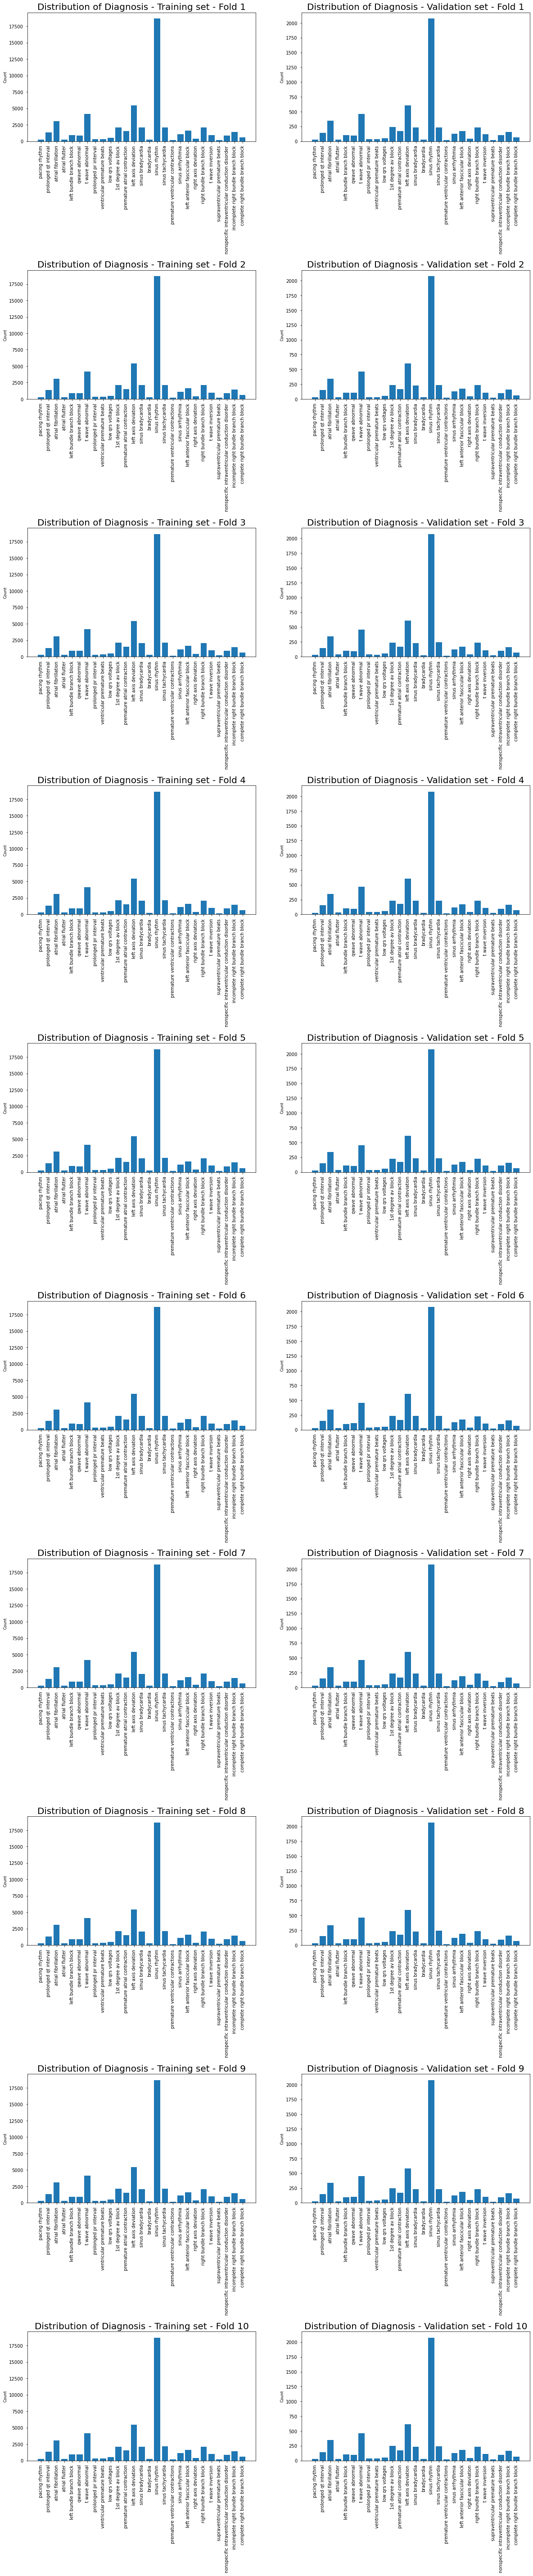

In [34]:
#@title The distribution of diagnosis in each Fold:
X_axis_labels=one_hot.classes_[0:-1]
plt.figure(figsize=(20,100))
h=1
for i in range(len(folds)):
    plt.subplot(10,2,h)
    plt.subplots_adjust(hspace=1.0)
    plt.bar(x= X_axis_labels, height=y[folds[i][0]].sum(axis=0))
    plt.title("Distribution of Diagnosis - Training set - Fold {}".format(i+1) ,fontsize="20", color = "black")
    plt.tick_params(axis="both", colors = "black")
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize = 10)
    #plt.xlabel("Diagnosis", color = "white")
    plt.ylabel("Count", color = "black")
    h=h+1
    plt.subplot(10,2,h)
    plt.subplots_adjust(hspace=1.0)
    plt.bar(x= X_axis_labels, height=y[folds[i][1]].sum(axis=0))
    plt.title("Distribution of Diagnosis - Validation set - Fold {}".format(i+1) ,fontsize="20", color = "black")
    plt.tick_params(axis="both", colors = "black")
    #plt.xlabel("Diagnosis", color = "white")
    plt.ylabel("Count", color = "black")
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize = 10)
    h=h+1

In [35]:
!pip install scikit-multilearn

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


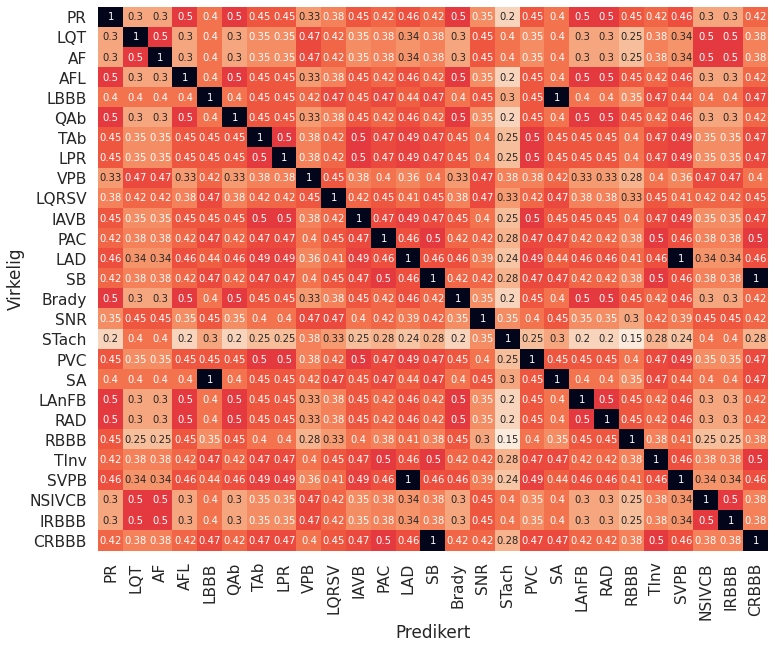

In [36]:
import seaborn as sns
conf_weights.columns = SNOMED_scored.iloc[:,0]
conf_weights.index = SNOMED_scored.iloc[:,0]

conf_weights = pd.DataFrame(conf_weights, columns=SNOMED_scored.iloc[:,0], index = SNOMED_scored.iloc[:,0])

conf_weights.columns=abbrev
conf_weights.index = abbrev
conf_weights.index.name = 'Virkelig'
conf_weights.columns.name = 'Predikert'

plt.figure(figsize = (12,10))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_weights, cmap="rocket_r", annot=True,cbar=False, annot_kws={"size": 10})# font size
plt.savefig("./confmatrix_weights.png",dpi=300)

In [37]:
!pip install arff

  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4969 sha256=47b0f067d7c8f396984ede55ed50aef873cf09407b03fd8a38310a5dd0357108
  Stored in directory: /root/.cache/pip/wheels/fe/81/bd/4ae90e24ba860304e375da219f9205b2586dbee255f3ee70e2
Successfully built arff
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [38]:
my_cluster = []
for i in range(len(y.T)):
    my_cluster.append(np.unique(np.where(y[np.where(y.T[i]==1)])[1]))

In [39]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

classifier_MLP = LabelSpacePartitioningClassifier(
    classifier = LabelPowerset(
        classifier= MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(100,100,100,100,100), verbose=1, max_iter=10, batch_size=100, learning_rate='adaptive', activation='relu',learning_rate_init=0.0001),
        require_dense = [False, True]
    ),
    require_dense = [True, True],
    clusterer = FixedLabelSpaceClusterer(clusters=my_cluster)
)

In [40]:
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.ensemble import MajorityVotingClassifier

classifier_cluster_chain = LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(
        classifier= RandomForestClassifier(n_jobs=-1,n_estimators=3, verbose=1,class_weight=None),
        require_dense = [False, True]
    ),
    require_dense = [True, True],
    clusterer = FixedLabelSpaceClusterer(clusters=my_cluster)
)

In [41]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.ensemble import MajorityVotingClassifier

classifier_rf_lb_cluster = LabelSpacePartitioningClassifier(
    classifier = LabelPowerset(
        classifier= RandomForestClassifier(n_jobs=-1,n_estimators=5, verbose=1),
        require_dense = [False, True]
    ),
    require_dense = [True, True],
    clusterer = FixedLabelSpaceClusterer(clusters=my_cluster)
)

In [42]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.ensemble import MajorityVotingClassifier

classifier_rf_lb_cluster_bal = LabelSpacePartitioningClassifier(
    classifier = LabelPowerset(
        classifier= RandomForestClassifier(n_jobs=-1,n_estimators=3, verbose=1, class_weight="balanced"),
        require_dense = [False, True]
    ),
    require_dense = [True, True],
    clusterer = FixedLabelSpaceClusterer(clusters=my_cluster)
)
# Score : 0.4961250109543675

In [43]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(200,200,200,200,200), verbose=1, max_iter=10, batch_size=100, learning_rate='adaptive', activation='relu',learning_rate_init=0.0001)

In [44]:
train_index = folds[0][0] 
val_index = folds[0][1]
    
X_train, X_val = np.asarray(X_data)[train_index], np.asarray(X_data)[val_index]
y_train, y_val = y[train_index], y[val_index]


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
print("Making a cluster")
my_cluster = []
for i in range(len(y_train.T)):
    my_cluster.append(np.unique(np.where(y_train[np.where(y_train.T[i]==1)])[1]))
print("Making the model")
classifier = LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(
        classifier= RandomForestClassifier(n_jobs=-1,n_estimators=5, verbose=1),
        require_dense = [False, True]
    ),
    require_dense = [True, True],
    clusterer = FixedLabelSpaceClusterer(clusters=my_cluster)
)
classifier.fit(X_train_scaled,y_train)

Making a cluster
Making the model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parall

LabelSpacePartitioningClassifier(classifier=ClassifierChain(classifier=RandomForestClassifier(n_estimators=5,
                                                                                              n_jobs=-1,
                                                                                              verbose=1),
                                                            require_dense=[False,
                                                                           True]),
                                 clusterer=FixedLabelSpaceClusterer(clusters=[array([ 0,  2,  4,  9, 11, 12, 13, 15, 19, 20, 22, 24, 25]),
                                                                              array([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19,
       20, 21, 22, 23, 24, 25, 26]),
                                                                              array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11...
       18, 19, 20, 21, 22, 24, 25, 26]),
             

In [45]:
from joblib import dump
dump(classifier, 'rand_forest_cluster_12lead.joblib') 

['rand_forest_cluster_12lead.joblib']

In [46]:
y_pred = classifier.predict(X_val_scaled)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

In [47]:
y_pred = y_pred.todense()
y_pred = np.asarray(y_pred)

In [48]:
print(np.argmax(y_pred, axis=1)[0:20])
print(np.argmax(y_val,axis=1)[0:20])

[16 15 15  2 11  4  0  0  2  0 15 21  4 10 10 11 15 21 21 23]
[ 0 15 15  2 11  4  0  0  2  0 10 21  4 11 21 15 15 21 21  0]


In [49]:
us.compute_challenge_metric_for_opt(y_val,y_pred)

0.5149304990230535

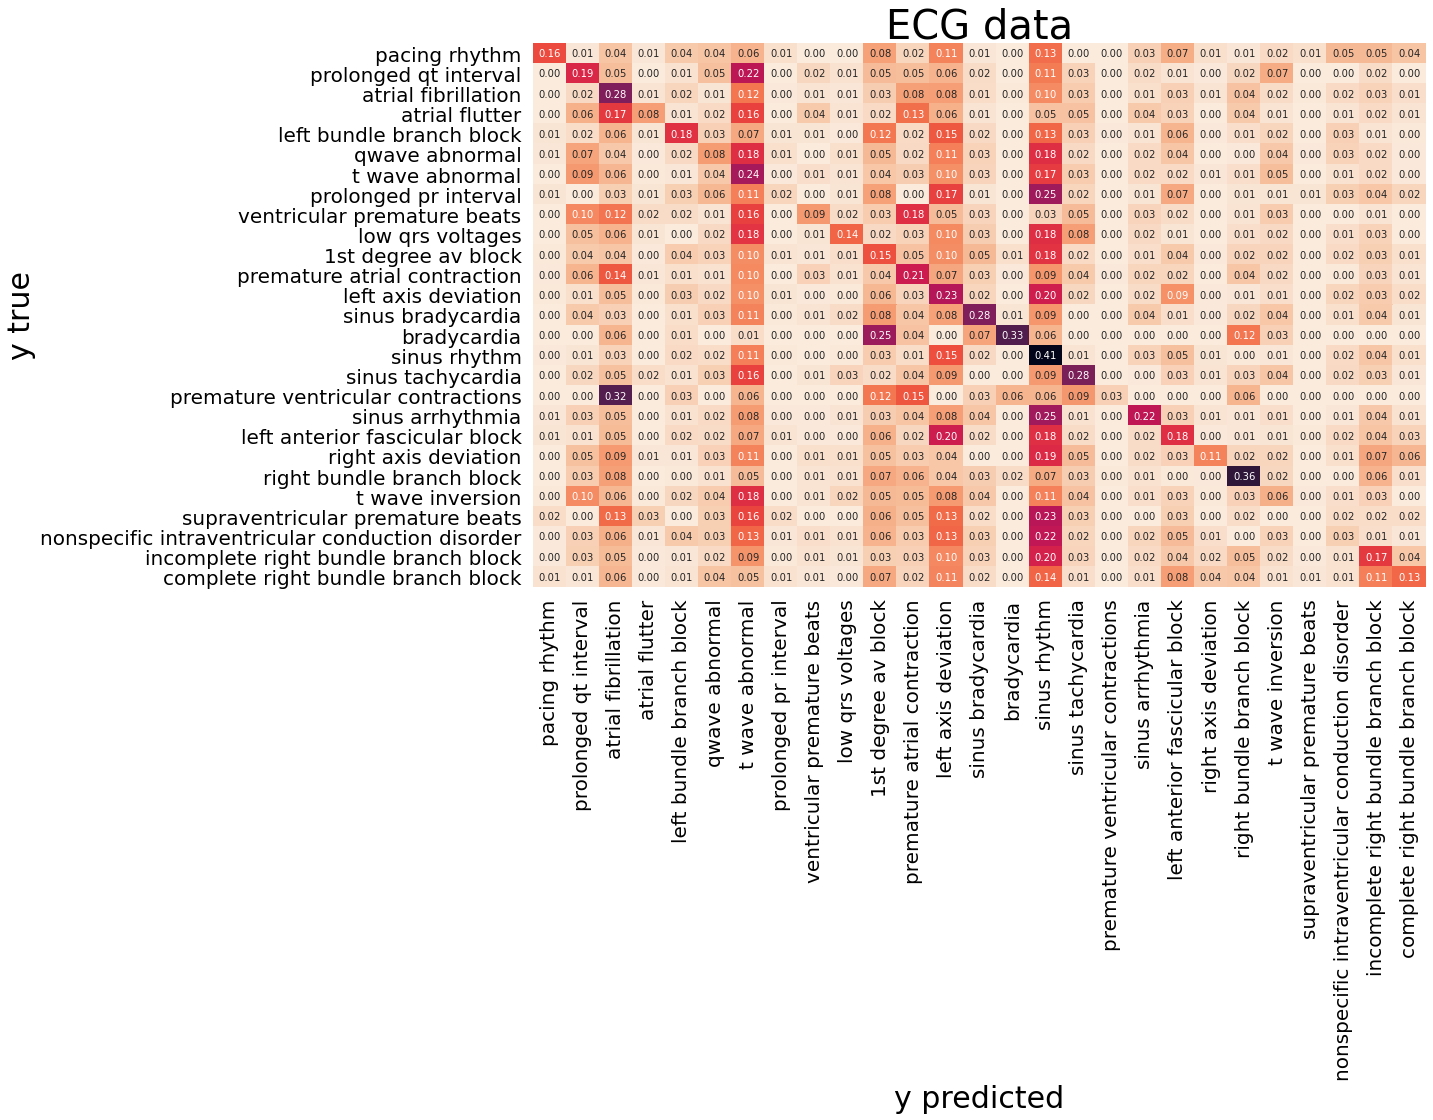

In [50]:
conf_matrix = us.compute_modified_confusion_matrix_nonorm(y_val,y_pred)

norm_conf_matrix = np.zeros((conf_matrix.shape[0], conf_matrix.shape[1]))

for i in range(conf_matrix.shape[0]):
    norm_conf_matrix[i]=conf_matrix[i]/conf_matrix[i].sum()

df_conf_matrix = pd.DataFrame(norm_conf_matrix, columns=one_hot.classes_[:-1], index = one_hot.classes_[:-1])
df_conf_matrix.index.name = 'y_true'
df_conf_matrix.columns.name = 'y_pred'


import seaborn as sns
plt.figure(figsize = (16,10))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_conf_matrix, cmap="rocket_r", annot=True,annot_kws={"size": 10}, fmt=".2f", cbar=False)
plt.title("ECG data", fontsize = 40, color= "black")
plt.xlabel("y predicted",fontsize=30, color= "black")
plt.ylabel("y true",fontsize = 30, color= "black")
plt.yticks(fontsize=20, rotation=0, color= "black")
plt.xticks(fontsize=20, rotation=90, color= "black")
plt.show()

In [51]:
'''
from joblib import load
clf_new = load('/content/drive/My Drive/logs/clf_Chain_rand_forest.joblib') 
'''

"\nfrom joblib import load\nclf_new = load('/content/drive/My Drive/logs/clf_Chain_rand_forest.joblib') \n"

In [52]:
!pip install lime

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [53]:
import lime
import lime.lime_tabular


In [54]:
FeatureNames = ['gender','age','R HR STD','R HR median','R HR min', 'R HR max','R HR mean','RMSSD','R amp II std','R amp II min','R amp II min_2', 'R amp leads I', 'R amp leads II', 'R amp lead III', 
                'R amp lead aVR','R amp lead aVL','R amp lead aVF', 'R amp V1','R amp V2','R amp V3','R amp V4','R amp V5','R amp V6','p_offset_std','p_offset_median','p_offset_min','p_offset_max',
                'mean_p_offset','p_onsets_std','p_onsets_median','p_onsets_min','p_onsets_max','mean_p_onsets','ECG_baseline','p_rate_std','p_rate_median','p_rate_min','p_rate_max','mean_p_rate', 
                'P amp leads I', 'P amp leads II', 'P amp lead III', 'P amp lead aVR','P amp lead aVL','P amp lead aVF', 'P amp V1','P amp V2','P amp V3','P amp V4','P amp V5','P amp V6','q_rate_std',
                'q_rate_median','q_rate_min','q_rate_max','mean_q_rate','Q amp leads I', 'Q amp leads II', 'Q amp lead III', 'Q amp lead aVR','Q amp lead aVL','Q amp lead aVF', 'Q amp V1','Q amp V2',
                'Q amp V3','Q amp V4','Q amp V5','Q amp V6','s_rate_std','s_rate_median','s_rate_min','s_rate_max','mean_s_rate','S amp leads I', 'S amp leads II', 'S amp lead III', 'S amp lead aVR',
                'S amp lead aVL','S amp lead aVF', 'S amp V1','S amp V2','S amp V3','S amp V4','S amp V5','S amp V6','t_rate_std','t_rate_median','t_rate_min','t_rate_max','mean_t_rate',
                'T amp leads I', 'T amp leads II', 'T amp lead III', 'T amp lead aVR','T amp lead aVL','T amp lead aVF', 'T amp V1','T amp V2','T amp V3','T amp V4','T amp V5','T amp V6','t_offset_std',
                't_offset_median','t_offset_min','t_offset_max','mean_t_offset','t_onsets_std','t_onsets_median','t_onsets_min','t_onsets_max','mean_t_onsets']

In [55]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_scaled,training_labels=y_train, mode='classification',feature_names=FeatureNames,class_names=abbrev)

In [56]:
class model_wrapper:
    # drf is the h2o distributed random forest object, the column_names is the
    # labels of the X values
    def __init__(self,model,column_names):
            
            self.model = model
            self.column_names = column_names
 
    def predict_proba(self,this_array):        
        # If we have just 1 row of data we need to reshape it
        shape_tuple = np.shape(this_array)        
        if len(shape_tuple) == 1:
            this_array = this_array.reshape(1, -1)
            
        # We convert the numpy array that Lime sends to a pandas dataframe and
        # convert the pandas dataframe to an h2o frame
        self.pandas_df = pd.DataFrame(data = this_array,columns = self.column_names)

        # Predict with the h2o drf
        self.predictions = self.model.predict(self.pandas_df).todense()
        # the first column is the class labels, the rest are probabilities for
        # each class
        self.predictions =  np.asarray(self.predictions)
        return self.predictions

In [57]:
classifier_wrapped_ =  model_wrapper(classifier,FeatureNames) 

In [58]:
one_hot.classes_[np.where(y_val[5]==1)]

array(['left bundle branch block'], dtype=object)

In [59]:
X_val_scaled = scaler.transform(X_val)

In [60]:
one_hot.classes_[np.where(y_val[689]==1)]

array(['atrial fibrillation',
       'nonspecific intraventricular conduction disorder'], dtype=object)

In [61]:
np.where(y_val[:,24]==1)[0][1]

689

In [62]:
one_hot.classes_[15]

'sinus rhythm'

In [63]:
#i = np.random.randint(0, X_test_scaled.shape[0])
exp = explainer.explain_instance(X_val_scaled[689], classifier_wrapped_.predict_proba, num_features=10, top_labels=27,num_samples=5000)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

In [64]:
exp.show_in_notebook(show_table=True, show_all=True)

In [65]:
exp.predict_proba

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [66]:
exp.as_map()

{0: [(94, -0.014182836710754302),
  (69, 0.014045222964899871),
  (88, -0.012720769986775224),
  (40, 0.012366951494680777),
  (71, -0.01222370846747728),
  (104, 0.011320130069109313),
  (25, 0.010966281491943085),
  (84, 0.010476353575307648),
  (97, -0.009939197432273419),
  (107, -0.009794449026881607)],
 24: [(76, 0.05849909719078713),
  (91, 0.05808242121537904),
  (21, 0.05552623165863724),
  (74, 0.043558148350251014),
  (61, 0.04208843964250258),
  (110, -0.04166971120138765),
  (22, 0.03938618112929002),
  (10, -0.037612669159879035),
  (104, -0.035859914727295855),
  (101, 0.03450024624116548)],
 23: [(40, 0.13824345304729727),
  (42, 0.11167902184025007),
  (44, 0.051774272935638105),
  (31, 0.04717662853528758),
  (30, 0.043111616329579446),
  (51, 0.04097427587033056),
  (11, 0.031538556807929274),
  (28, 0.030946412000865696),
  (57, -0.028843643863653186),
  (74, 0.027420531328399434)],
 22: [(93, 0.2050873991292547),
  (99, 0.16032471911646443),
  (91, 0.15221572143070

In [67]:
exp.as_list(label=)

SyntaxError: invalid syntax (<ipython-input-67-84724be91a49>, line 1)

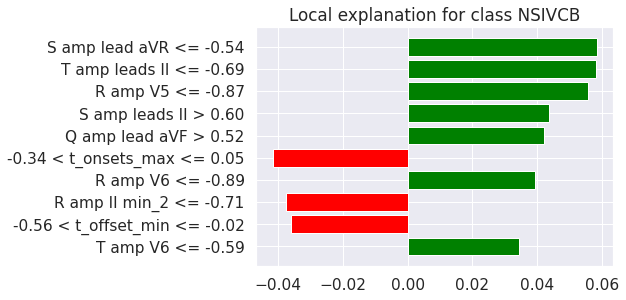

In [68]:
exp.as_pyplot_figure(label=24)
plt.savefig("conduction_disorder_12lead.png", dpi=300, bbox_inches="tight")

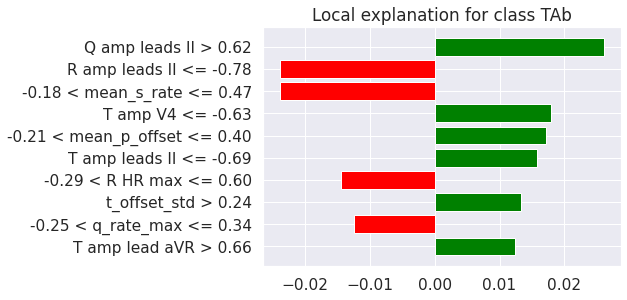

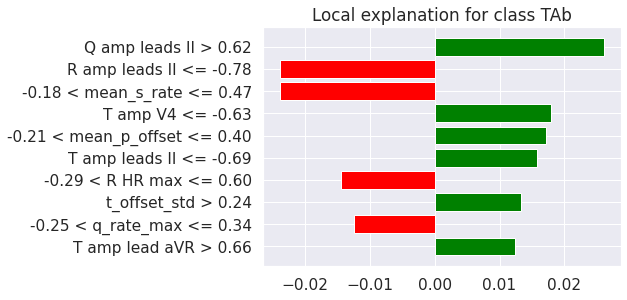

In [69]:
exp.as_pyplot_figure(label=6)
#plt.savefig("atrialfib_atrialfib.png", dpi=300, bbox_inches="tight")

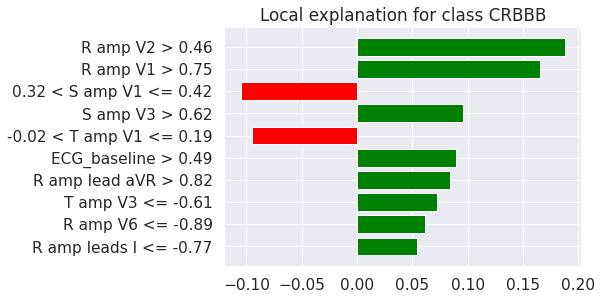

In [70]:
exp.as_pyplot_figure(label=26)
plt.savefig("atrialfib_crbbb.png", dpi=300, bbox_inches="tight")

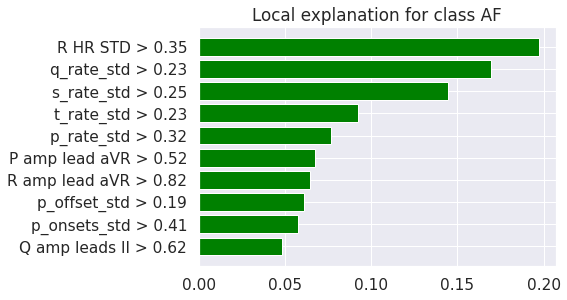

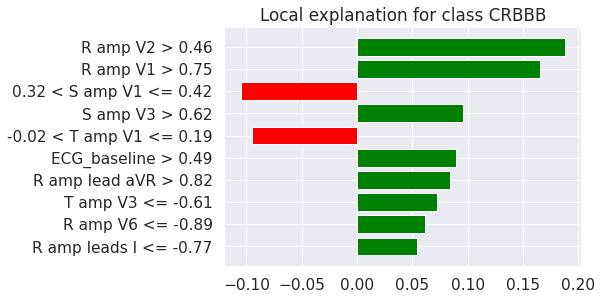

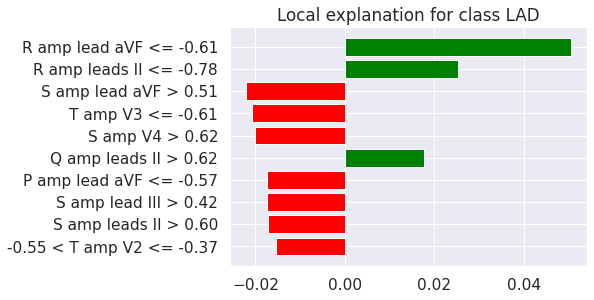

In [71]:
exp.as_pyplot_figure(label=2)
exp.as_pyplot_figure(label=26)
exp.as_pyplot_figure(label=12)
plt.show()

In [72]:
exp.save_to_file("explaination.html")

In [73]:
SNOMED_scored

Dx  SNOMED CT Code  \
0                                1st degree av block       270492004   
1                                atrial fibrillation       164889003   
2                                     atrial flutter       164890007   
3                                        bradycardia       426627000   
4                 complete right bundle branch block       713427006   
5               incomplete right bundle branch block       713426002   
6                     left anterior fascicular block       445118002   
7                                left axis deviation        39732003   
8                           left bundle branch block       164909002   
9                                   low qrs voltages       251146004   
10  nonspecific intraventricular conduction disorder       698252002   
11                                     pacing rhythm        10370003   
12                      premature atrial contraction       284470004   
13                premature ventricular contractions       427172004   
14                             prolonged pr interval       164947007   
15                             prolonged qt interval       111975006   
16                                    qwave abnormal       164917005   
17                              right axis deviation        47665007   
18                         right bundle branch block        59118001   
19                                  sinus arrhythmia       427393009   
20                                 sinus bradycardia       426177001   
21                                      sinus rhythm       426783006   
22                                 sinus tachycardia       427084000   
23                  supraventricular premature beats        63593006   
24                                   t wave abnormal       164934002   
25                                  t wave inversion        59931005   
26                       ventricular premature beats        17338001   

   Abbreviation  CPSC  CPSC-Extra  StPetersburg  PTB  PTB-XL  Georgia  Total  \
0          IAVB   722         106             0    0     797      769   2394   
1            AF  1221         153             2   15    1514      570   3475   
2           AFL     0          54             0    1      73      186    314   
3         Brady     0         271            11    0       0        6    288   
4         CRBBB     0         113             0    0     542       28    683   
5         IRBBB     0          86             0    0    1118      407   1611   
6         LAnFB     0           0             0    0    1626      180   1806   
7           LAD     0           0             0    0    5146      940   6086   
8          LBBB   236          38             0    0     536      231   1041   
9         LQRSV     0           0             0    0     182      374    556   
10       NSIVCB     0           4             1    0     789      203    997   
11           PR     0           3             0    0     296        0    299   
12          PAC   616          73             3    0     398      639   1729   
13          PVC     0         188             0    0       0        0    188   
14          LPR     0           0             0    0     340        0    340   
15          LQT     0           4             0    0     118     1391   1513   
16          QAb     0           1             0    0     548      464   1013   
17          RAD     0           1             0    0     343       83    427   
18         RBBB  1857           1             2    0       0      542   2402   
19           SA     0          11             2    0     772      455   1240   
20           SB     0          45             0    0     637     1677   2359   
21          SNR   918           4             0   80   18092     1752  20846   
22        STach     0         303            11    1     826     1261   2402   
23         SVPB     0          53             4    0     157        1    215   
24          TAb     0          22